# Direct Neural Biasing - Python Demo

## STEP 1 - Python Imports

In [1]:
from pathlib import Path
from time import time
import math
import json
import csv
import re

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne
import direct_neural_biasing as dnb

## STEP 2 - Define Data Array

#### 2.1 - Read EDF File

In [2]:
file = './data/JS.edf' # place an EDF file in the /data dir

raw = mne.io.read_raw_edf(file)
sample_freq = raw.info["sfreq"]
data_full = raw.get_data().flatten()

Extracting EDF parameters from C:\data\UCL\DirectNeuralBiasing\src\pythonlib\data\JS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\dan\AppData\Local\Temp/ipykernel_9792/3436388220.py:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file)


In [3]:
# Temporary hack that imports 'data' from CSV 
# data = pd.read_csv('signal.csv').values.flatten()

#### 2.2 - Truncate data array for debug

In [4]:
data = data_full[:100000]

In [5]:
# Optional write data to csv
filename = 'data.csv'
np.savetxt(filename, data, delimiter=',')

print(f'Array saved to {filename}')

Array saved to data.csv


#### 2.2 ALT - Read Sample CSV

## STEP 3 - Setup SignalProcesser

#### 3.1 - Create Signal Processor

In [6]:
verbose = True # verbose=True gives more verbose output in results object for debugging
signal_processor = dnb.PySignalProcessor(verbose)

#### 3.2 - Create Filters

In [7]:
slow_wave_filter_id = 'bandpass_filter_slow_wave'
f_low = 0.5 # cutoff_low
f_high = 4.0 # cutoff_high
sample_freq = sample_freq # signal sample rate

signal_processor.add_filter(slow_wave_filter_id, f_low, f_high, sample_freq)

In [8]:
ied_filter_id = 'bandpass_filter_ied'
f_low = 80.0 # cutoff_low
f_high = 120.0 # cutoff_high
sample_freq = sample_freq # signal sample rate

signal_processor.add_filter(ied_filter_id, f_low, f_high, sample_freq)

#### 3.3 - Create Slow Wave Detector

In [9]:
slow_wave_detector_id = 'slow_wave_detector'
z_score_threshold = 1.0 # candidate wave amplitude threhsold
sinusoidness_threshold = 0.5 # cosine wave correlation, between 0 and 1.

signal_processor.add_slow_wave_detector(
    slow_wave_detector_id,
    slow_wave_filter_id, # which filtered_signal should the detector read from
    z_score_threshold,
    sinusoidness_threshold,
)

#### 3.4 - Create IED Detector

In [10]:
ied_detector_id = 'ied_detector'
z_score_threshold = 3.0 # threhsold for candidate detection event
buffer_size = 10 # length of buffer - to manage noise resistance
sensitivy = 0.5 # Between 0 and 1. Ratio of values in buffer OVER threshold required to trigger an 'IED Detected' event.

signal_processor.add_threshold_detector(
    ied_detector_id,
    ied_filter_id, # which filtered_signal should the detector read from
    z_score_threshold,
    buffer_size,
    sensitivy
)

#### 3.5 - Create Pulse Trigger

In [11]:
trigger_id = 'pulse_trigger'
inhibition_cooldown_ms = 2000 # duration in seconds for cooldown after IED detection
pulse_cooldown_ms = 2000 # duration in ms ms cooldown after pulse event

signal_processor.add_pulse_trigger(
    trigger_id,
    slow_wave_detector_id, # which detector triggers a pulse - SlowWave in this case
    ied_detector_id, # which detector triggers an inhibition cooldown - IED in this case
    inhibition_cooldown_ms,
    pulse_cooldown_ms
)

## STEP 4 - Analyse Signal

#### 4.1 - Run

In [12]:
out = signal_processor.run(data)

#### 4.2 - Example Sample Output

In [13]:
len(out)

100000

In [14]:
out[0]

{'global:raw_sample': -4.3945983062485706e-07,
 'triggers:pulse_trigger:activation_active': 0.0,
 'detectors:ied_detector:detected': 0.0,
 'detectors:ied_detector:statistics:std_dev': 0.0,
 'triggers:pulse_trigger:inhibition_active': 0.0,
 'detectors:ied_detector:statistics:count': 1.0,
 'global:index': 0.0,
 'detectors:ied_detector:confidence': 0.0,
 'detectors:slow_wave_detector:detected': 0.0,
 'filters:bandpass_filter_ied:filtered_sample': -5.697968110773623e-08,
 'detectors:ied_detector:statistics:mean': -5.697968110773623e-08,
 'detectors:ied_detector:statistics:z_score': 0.0,
 'triggers:pulse_trigger:triggered': 0.0,
 'detectors:ied_detector:statistics:sum_of_squares': 3.246684059139313e-15,
 'detectors:ied_detector:statistics:sum': -5.697968110773623e-08,
 'filters:bandpass_filter_slow_wave:filtered_sample': -2.54691634563262e-10}

#### 4.3 - Save Output as CSV

In [15]:
# Define the output file name
output_file = 'output.csv'

# Collect all unique keys from all dictionaries in the list
unique_keys = set()
for row in out:
    unique_keys.update(row.keys())

# Convert the set of unique keys to a list and sort it to ensure consistent column order
headers = sorted(unique_keys)

# Write the data to a CSV file
with open(output_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=headers)
    writer.writeheader()  # Write the header row
    for row in out:
        # Ensure each row has all headers, filling missing values with None or an empty string
        writer.writerow({key: row.get(key, None) for key in headers})

print(f'Data successfully written to {output_file}')

Data successfully written to output.csv


## STEP 5 - Check Filtered Signal Against Scipy

#### 5.1 - Prepare Signal Arrays

In [16]:
raw_signal = data
dnb_raw_signal = [sample['global:raw_sample'] for sample in out]
dnb_slow_wave_filtered_signal = [sample[f'filters:{slow_wave_filter_id}:filtered_sample'] for sample in out]
dnb_ied_filtered_signal = [sample[f'filters:{ied_filter_id}:filtered_sample'] for sample in out]

#### 5.2 - Create Scipy Filtered Signals

##### 5.2.3 - SlowWave Filter Test

In [17]:
# SciPy filtering parameters
order = 2
lowcut = 0.25  # Low cut frequency in Hz
highcut = 4.0  # High cut frequency in Hz

# Design a Butterworth bandpass filter using SciPy
b, a = signal.butter(order, [lowcut, highcut], 'bp', fs= sample_freq)

# Apply the filter to the raw signal using SciPy
scipy_filtered_signal_slowwave_test = signal.lfilter(b, a, raw_signal)

##### 5.2.1 - IED Filter Test

In [18]:
# SciPy filtering parameters
order = 2
lowcut = 80.0  # Low cut frequency in Hz
highcut = 120.0  # High cut frequency in Hz

# Design a Butterworth bandpass filter using SciPy
b, a = signal.butter(order, [lowcut, highcut], 'bp', fs= sample_freq)

# Apply the filter to the raw signal using SciPy
scipy_filtered_signal_ied_test = signal.lfilter(b, a, raw_signal)

#### 5.3 - Truncate Signals for Easier Debug

In [19]:
start_idx = 0
end_idx = 1000

raw_signal_truncated = raw_signal[start_idx:end_idx]
dnb_raw_signal_truncated = dnb_raw_signal[start_idx:end_idx]
dnb_slow_wave_filtered_signal_truncated = dnb_slow_wave_filtered_signal[start_idx:end_idx]
dnb_ied_filtered_signal_truncated = dnb_ied_filtered_signal[start_idx:end_idx]
scipy_filtered_signal_slowwave_test_truncated = scipy_filtered_signal_slowwave_test[start_idx:end_idx]
scipy_filtered_signal_ied_test_truncated = scipy_filtered_signal_ied_test[start_idx:end_idx]

#### 5.4 - Plot Graphs

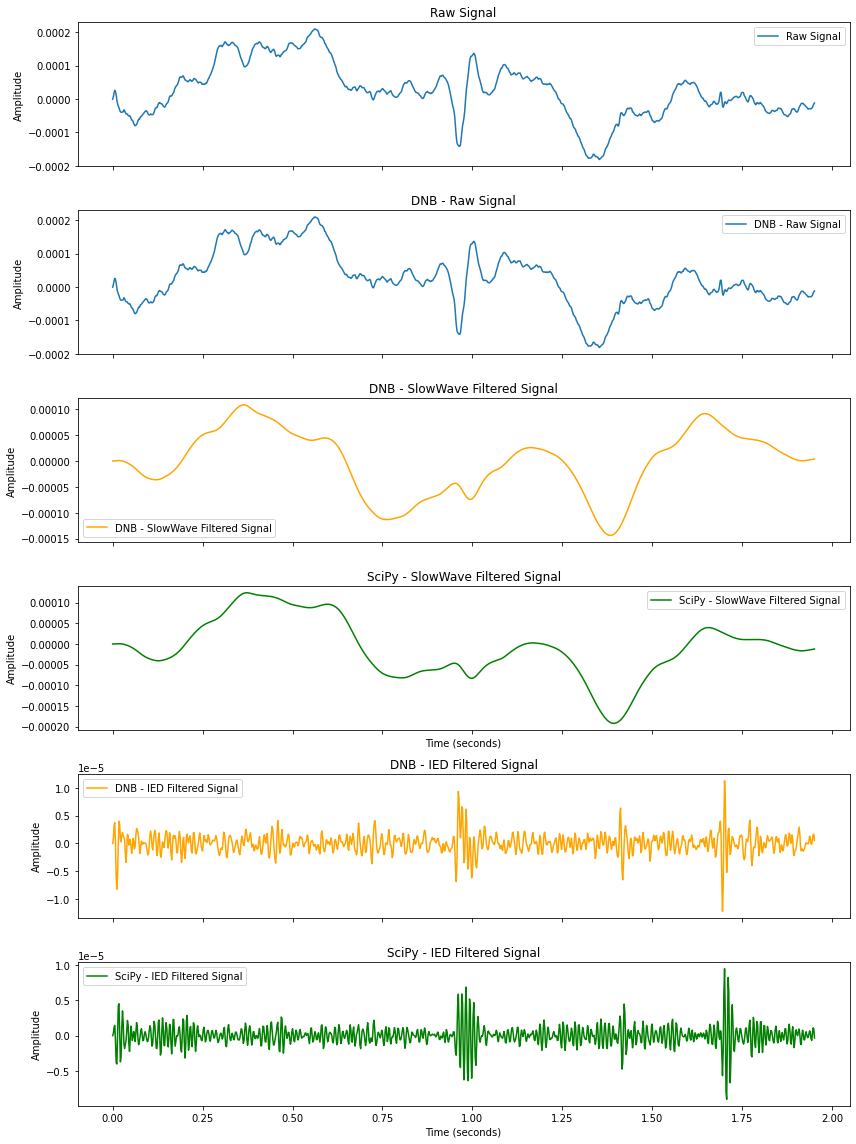

In [20]:
# Convert sample indices to time in seconds
time = np.arange(len(raw_signal_truncated)) / sample_freq

# Plot the four graphs
fig, axs = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

# Plot the raw signal
axs[0].plot(time, raw_signal_truncated, label='Raw Signal')
axs[0].set_title('Raw Signal')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

# Plot the dnb_raw signal
axs[1].plot(time, dnb_raw_signal_truncated, label='DNB - Raw Signal')
axs[1].set_title('DNB - Raw Signal')
axs[1].set_ylabel('Amplitude')
axs[1].legend()

# Plot the dnb_filtered signal
axs[2].plot(time, dnb_slow_wave_filtered_signal_truncated, label='DNB - SlowWave Filtered Signal', color='orange')
axs[2].set_title('DNB - SlowWave Filtered Signal')
axs[2].set_ylabel('Amplitude')
axs[2].legend()

# Plot the sciPy_filtered signal
axs[3].plot(time, scipy_filtered_signal_slowwave_test_truncated, label='SciPy - SlowWave Filtered Signal', color='green')
axs[3].set_title('SciPy - SlowWave Filtered Signal')
axs[3].set_xlabel('Time (seconds)')
axs[3].set_ylabel('Amplitude')
axs[3].legend()

# Plot the dnb_filtered signal
axs[4].plot(time, dnb_ied_filtered_signal_truncated, label='DNB - IED Filtered Signal', color='orange')
axs[4].set_title('DNB - IED Filtered Signal')
axs[4].set_ylabel('Amplitude')
axs[4].legend()

# Plot the sciPy_filtered signal
axs[5].plot(time, scipy_filtered_signal_ied_test_truncated, label='SciPy - IED Filtered Signal', color='green')
axs[5].set_title('SciPy - IED Filtered Signal')
axs[5].set_xlabel('Time (seconds)')
axs[5].set_ylabel('Amplitude')
axs[5].legend()

# Show the plots
plt.tight_layout()
plt.show()

## STEP 6 - Find Detected Events & Display JSON

#### 6.1 - Find Events

In [21]:
events = [item for item in out if item[f'triggers:{trigger_id}:triggered'] == 1.0]

In [22]:
len(events)

1

#### 6.2 - Display JSON with nice structure

In [23]:
# Initialize an empty dictionary to hold structured data
structured_data = {}

# Iterate through each event in the list
for idx, event in enumerate(events):
    event_key = f'event_{idx}'
    structured_data[event_key] = {'detectors': {}, 'global': {}, 'filters': {}, 'triggers': {}}
    
    for key, value in event.items():
        category, sub_key = key.split(':', 1)
        
        if category == 'detectors':
            detector_type, detector_key = sub_key.split(':', 1)
            if detector_type not in structured_data[event_key]['detectors']:
                structured_data[event_key]['detectors'][detector_type] = {}
            structured_data[event_key]['detectors'][detector_type][detector_key] = value
        
        elif category == 'filters':
            filter_type, filter_key = sub_key.split(':', 1)
            if filter_type not in structured_data[event_key]['filters']:
                structured_data[event_key]['filters'][filter_type] = {}
            structured_data[event_key]['filters'][filter_type][filter_key] = value
        
        elif category == 'triggers':
            trigger_type, trigger_key = sub_key.split(':', 1)
            if trigger_type not in structured_data[event_key]['triggers']:
                structured_data[event_key]['triggers'][trigger_type] = {}
            structured_data[event_key]['triggers'][trigger_type][trigger_key] = value
        
        elif category == 'global':
            structured_data[event_key]['global'][sub_key] = value

# Convert back to float NaN where necessary
def convert_nan(value):
    return value if not isinstance(value, float) or not math.isnan(value) else float('nan')

for event_key, categories in structured_data.items():
    for category_key, sub_categories in categories.items():
        if isinstance(sub_categories, dict):
            for sub_category_key, values in sub_categories.items():
                if isinstance(values, dict):
                    for value_key, value in values.items():
                        structured_data[event_key][category_key][sub_category_key][value_key] = convert_nan(value)
                else:
                    structured_data[event_key][category_key][sub_category_key] = convert_nan(values)

# Print the final structured data with NaN values converted
print(json.dumps(structured_data, indent=4))

{
    "event_0": {
        "detectors": {
            "slow_wave_detector": {
                "mean_wave": -0.6193829380832391,
                "std_dev_wave": 0.415541769082707,
                "predicted_next_maxima_index": 9769.0,
                "downwave_end_index": 9584.0,
                "mean_sinusoid": 5.386526804111272e-17,
                "sinusoidness": 84.47210992822812,
                "covariance": 35.088604810399325,
                "downwave_start_index": 9214.0,
                "detected": 1.0,
                "std_dev_sinusoid": 0.9996272205889135,
                "peak_z_score_amplitude": 1.4136863726741633
            },
            "ied_detector": {
                "detected": 0.0,
                "statistics:std_dev": 1.5015427405648678e-06,
                "statistics:count": 9585.0,
                "confidence": 0.0,
                "statistics:mean": -9.895065971301584e-11,
                "statistics:z_score": -2.091957074431914,
                "statistics:s

## STEP 7 - Visualise Detected Events

downwave_start_idx: 9214, downwave_end_idx: 9584, predicted_next_maxima_idx: 9769
start_idx: 8474, end_idx: 10324
segment length: 1850, time length: 1850
event_times length: 370, event_segment length: 370


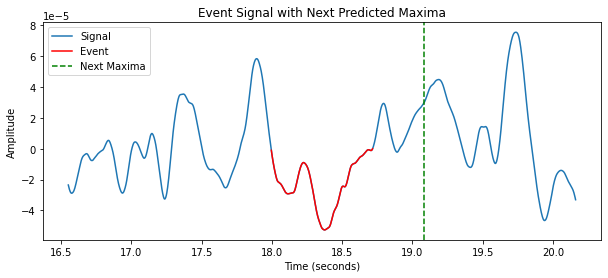

downwave_start_idx: 618510, downwave_end_idx: 619047, predicted_next_maxima_idx: 619316
start_idx: 617436, end_idx: 620121
segment length: 2685, time length: 2685
event_times length: 537, event_segment length: 537


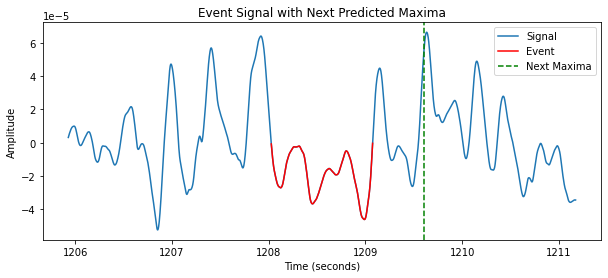

downwave_start_idx: 1198489, downwave_end_idx: 1198884, predicted_next_maxima_idx: 1199082
start_idx: 1197699, end_idx: 1199674
segment length: 1975, time length: 1975
event_times length: 395, event_segment length: 395


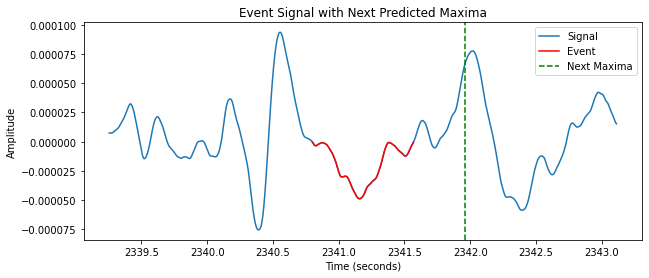

downwave_start_idx: 1750073, downwave_end_idx: 1750382, predicted_next_maxima_idx: 1750537
start_idx: 1749455, end_idx: 1751000
segment length: 1545, time length: 1545
event_times length: 309, event_segment length: 309


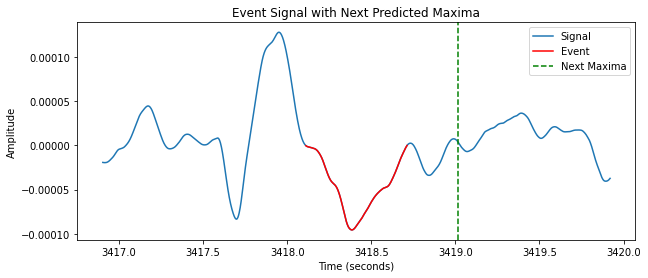

downwave_start_idx: 2268211, downwave_end_idx: 2268501, predicted_next_maxima_idx: 2268646
start_idx: 2267631, end_idx: 2269081
segment length: 1450, time length: 1450
event_times length: 290, event_segment length: 290


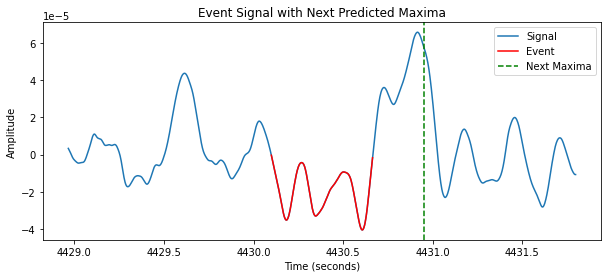

downwave_start_idx: 2846065, downwave_end_idx: 2846301, predicted_next_maxima_idx: 2846419
start_idx: 2845593, end_idx: 2846773
segment length: 1180, time length: 1180
event_times length: 236, event_segment length: 236


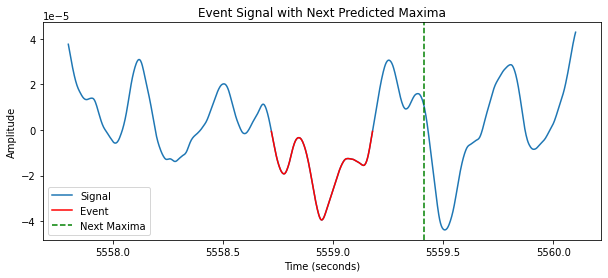

downwave_start_idx: 3422536, downwave_end_idx: 3422788, predicted_next_maxima_idx: 3422914
start_idx: 3422032, end_idx: 3423292
segment length: 1260, time length: 1260
event_times length: 252, event_segment length: 252


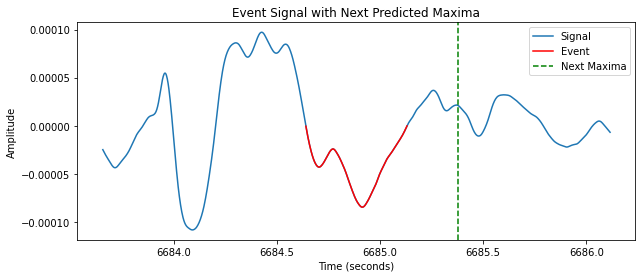

downwave_start_idx: 3918860, downwave_end_idx: 3919146, predicted_next_maxima_idx: 3919289
start_idx: 3918288, end_idx: 3919718
segment length: 1430, time length: 1430
event_times length: 286, event_segment length: 286


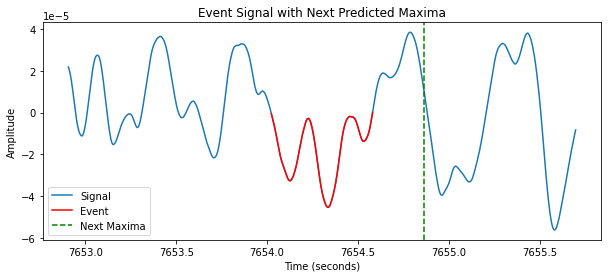

downwave_start_idx: 4470414, downwave_end_idx: 4470667, predicted_next_maxima_idx: 4470794
start_idx: 4469908, end_idx: 4471173
segment length: 1265, time length: 1265
event_times length: 253, event_segment length: 253


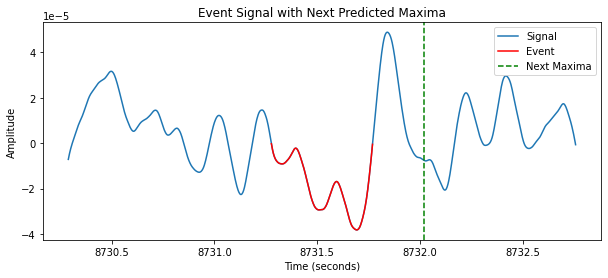

downwave_start_idx: 5015956, downwave_end_idx: 5016151, predicted_next_maxima_idx: 5016249
start_idx: 5015566, end_idx: 5016541
segment length: 975, time length: 975
event_times length: 195, event_segment length: 195


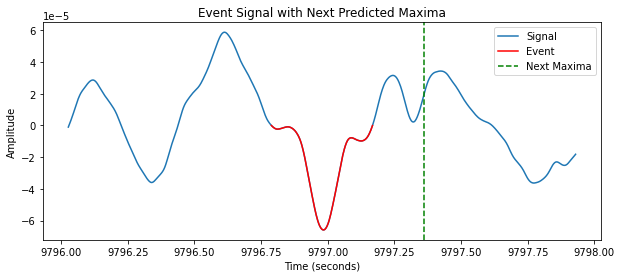

downwave_start_idx: 5532471, downwave_end_idx: 5532687, predicted_next_maxima_idx: 5532795
start_idx: 5532039, end_idx: 5533119
segment length: 1080, time length: 1080
event_times length: 216, event_segment length: 216


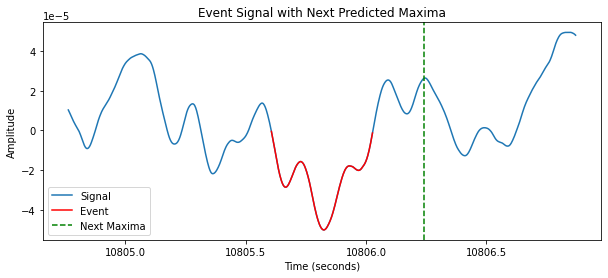

downwave_start_idx: 6086755, downwave_end_idx: 6086979, predicted_next_maxima_idx: 6087091
start_idx: 6086307, end_idx: 6087427
segment length: 1120, time length: 1120
event_times length: 224, event_segment length: 224


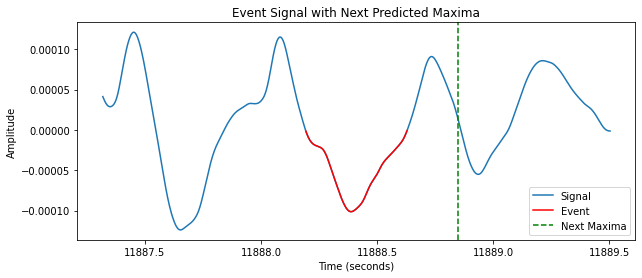

downwave_start_idx: 7189664, downwave_end_idx: 7189851, predicted_next_maxima_idx: 7189945
start_idx: 7189290, end_idx: 7190225
segment length: 935, time length: 935
event_times length: 187, event_segment length: 187


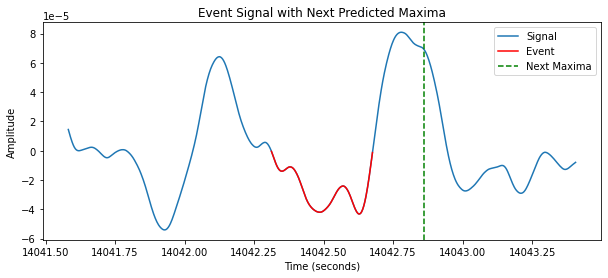

downwave_start_idx: 8228424, downwave_end_idx: 8228555, predicted_next_maxima_idx: 8228621
start_idx: 8228162, end_idx: 8228817
segment length: 655, time length: 655
event_times length: 131, event_segment length: 131


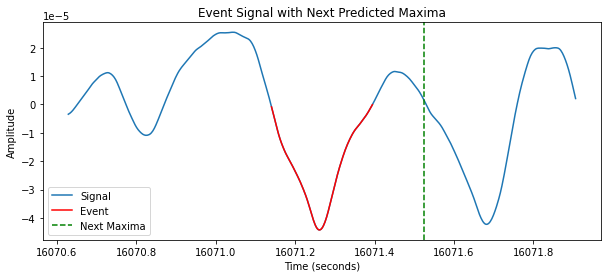

downwave_start_idx: 8770717, downwave_end_idx: 8770876, predicted_next_maxima_idx: 8770956
start_idx: 8770399, end_idx: 8771194
segment length: 795, time length: 795
event_times length: 159, event_segment length: 159


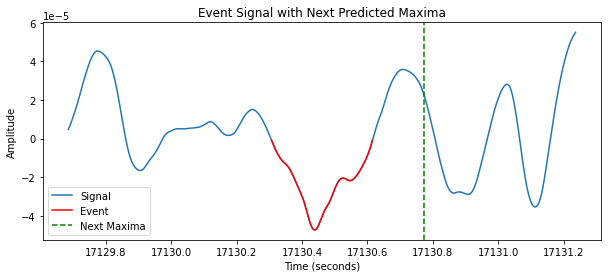

downwave_start_idx: 9323003, downwave_end_idx: 9323667, predicted_next_maxima_idx: 9323999
start_idx: 9321675, end_idx: 9324995
segment length: 3320, time length: 3320
event_times length: 664, event_segment length: 664


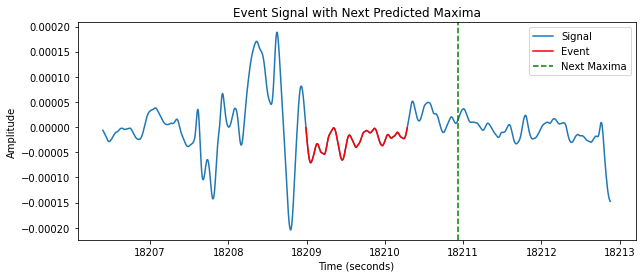

downwave_start_idx: 9875574, downwave_end_idx: 9875876, predicted_next_maxima_idx: 9876027
start_idx: 9874970, end_idx: 9876480
segment length: 1510, time length: 1510
event_times length: 302, event_segment length: 302


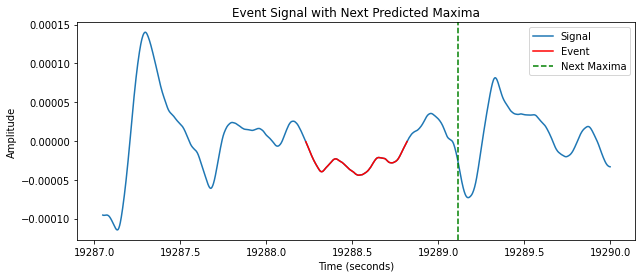

In [57]:
signal_padding_factor = 2

# Function to extract indices and plot each event
def plot_trigger_events(data, events, signal_padding_factor, sample_freq):
    for event in events:
        # Extract the indices from the event keys
        downwave_start_idx = int(event.get('detectors:slow_wave_detector:downwave_start_index', -1))
        downwave_end_idx = int(event.get('detectors:slow_wave_detector:downwave_end_index', -1))
        predicted_next_maxima_idx = int(event.get('detectors:slow_wave_detector:predicted_next_maxima_index', -1))

        if downwave_start_idx == -1 or downwave_end_idx == -1 or predicted_next_maxima_idx == -1:
            continue  # Skip if any of the indices are invalid

        # Debugging the indices
        print(f"downwave_start_idx: {downwave_start_idx}, downwave_end_idx: {downwave_end_idx}, predicted_next_maxima_idx: {predicted_next_maxima_idx}")

        # Determine the range for plotting
        event_length = downwave_end_idx - downwave_start_idx
        extra_length = event_length * signal_padding_factor
        start_idx = max(0, downwave_start_idx - extra_length)
        end_idx = min(len(data), downwave_end_idx + extra_length)

        # Extract the signal segment to plot
        segment = data[start_idx:end_idx]

        # Convert indices to time in seconds
        time = np.arange(start_idx, end_idx) / sample_freq

        # Debugging lengths
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        print(f"segment length: {len(segment)}, time length: {len(time)}")

        # Plot the signal segment
        plt.figure(figsize=(10, 4))
        plt.plot(time, segment, label='Signal')

        # Highlight the event signal
        event_times = np.arange(downwave_start_idx, downwave_end_idx) / sample_freq
        event_segment = data[downwave_start_idx:downwave_end_idx]

        # Debugging event lengths
        print(f"event_times length: {len(event_times)}, event_segment length: {len(event_segment)}")

        # Ensure the lengths of event_times and event_segment match
        if len(event_times) != len(event_segment):
            print(f"Event length mismatch: event_times({len(event_times)}), event_segment({len(event_segment)})")
            continue

        plt.plot(event_times, event_segment, color='red', label='Event')

        # Plot the predicted next maxima as a green vertical line
        next_maxima_time = predicted_next_maxima_idx / sample_freq
        plt.axvline(x=next_maxima_time, color='green', linestyle='--', label='Next Maxima')

        # Add labels and legend
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('Event Signal with Next Predicted Maxima')
        plt.ticklabel_format(useOffset=False)
        plt.legend()
        plt.show()

# Example usage
# Assuming `data` is your signal array and `events` is your list of event dictionaries
plot_trigger_events(dnb_slow_wave_filtered_signal, events, signal_padding_factor, sample_freq)


## DEBUG - VISUALISE IED EVENTS

#### NOTE - There is no cooldown on IED detection, so each IED results in multiple 'detections'

In [ ]:
ied_detections = [item for item in out if item[f'detectors:{ied_detector_id}:detected'] == 1.0]

In [ ]:
signal_padding_factor = 2

# Function to extract indices and plot each event
def plot_ied_events(data, detections, signal_padding_factor, sample_freq):
    for detection in detections:
        # Extract the index of the IED event
        ied_idx = detection.get('global:index')

        # Debugging the index
        print(f"ied_idx: {ied_idx}")

        # Determine the range for plotting
        extra_length = signal_padding_factor * sample_freq
        start_idx = int(max(0, ied_idx - extra_length))
        end_idx = int(min(len(data), ied_idx + extra_length))

        # Extract the signal segment to plot
        segment = data[start_idx:end_idx]

        # Convert indices to time in seconds
        time = np.arange(start_idx, end_idx) / sample_freq

        # Debugging lengths
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        print(f"segment length: {len(segment)}, time length: {len(time)}")

        # Plot the signal segment
        plt.figure(figsize=(10, 4))
        plt.plot(time, segment, label='Signal')

        # Highlight the IED event
        ied_time = ied_idx / sample_freq
        plt.axvline(x=ied_time, color='red', linestyle='--', label='IED Event')

        # Add labels and legend
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title('IED Event Signal')
        plt.ticklabel_format(useOffset=False)
        plt.legend()
        plt.show()

# Example usage
# Assuming `data` is your signal array and `events` is your list of event dictionaries
plot_ied_events(dnb_ied_filtered_signal, ied_detections, signal_padding_factor, sample_freq)